In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

from kernel import *
from MMD import *
from feedback import *

from tqdm import tqdm_notebook

%load_ext autoreload
%autoreload 2

# Question 2 : Data generation

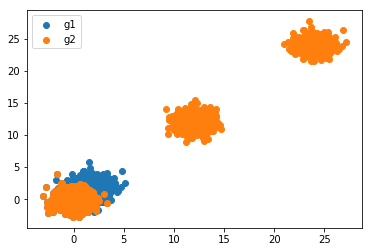

In [2]:
def gaussian_mix(d,N,t,n,s=1, seed=1):
    np.random.seed(seed)
    cov = np.identity(d)
    mean = np.zeros(d)
    n_tot = N*n
    res = np.zeros((d,n_tot))
    for i in range(N):
        gaus = np.random.multivariate_normal(mean + t*i, cov*(s**i),n).T
        for j in range(d):
            res[j][i*n:(i+1)*n] = gaus[j]
            
    return(res)  

g1 = gaussian_mix(d=2,N=3,t=1,n=500, seed=1) 
g2 = gaussian_mix(d=2,N=3,t=12,n=500, seed=1) 

plt.scatter(g1[0], g1[1], label="g1")
plt.scatter(g2[0], g2[1], label="g2")
plt.legend()
plt.show()

# Question 3 : MMD and type I error

The MMD test is now implemented.

#### TODO : Propose a strategy to check whether MMD is a test of level α. Then, present experiments on the gaussian data. Discuss the results.

The level alpha of a test is an upper bound of the probability of type I error (rejecting H0 while it is true).
A TST of level alpha using MMD as test statistic has the acceptance region  : MMD <= sqrt(2K/m) (1 + sqrt(2log(1/alpha))).
We have to check if the probability of rejecting H0 while it is true (type I error) with the MMD TST is upper-bounded by alpha.

Update 20190426:

We should be careful about what the parameter alpha is.

By looking at the shape of the decision region : the threshold of level alpha is stricly decreasing with respect to alpha, and as the acceptance region is defined as "accept H0" if the test statistic is below alpha, alpha should be large ie 95% and not 5%. We should then verify that the probability of rejecting H0 while it is true is less than 1 - alpha = 0.05.

Experiments are conducted with MMD_b and MMD_u in the following section.

+ What can be seen is that for MMD_b, parameter alpha = 0.05 produces no error under H0 but alpha = 0.95 does some and alpha = 0.99 even more. Although we still have that the probability of rejecting H0 under H0=0.0091 <= 1-alpha=0.01 hence the test is verified.

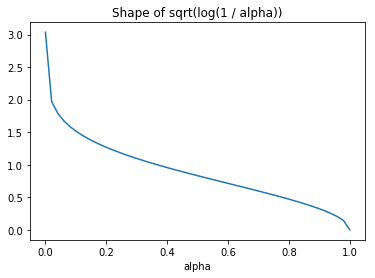

In [12]:
x = np.linspace(0.0001, 1)
y = np.sqrt(np.log(1 / x))
plt.plot(x, y)
plt.title("Shape of sqrt(log(1 / alpha))")
plt.xlabel('alpha')
plt.show()

In [3]:
%%time
kernel_class = GaussianKernel()
test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)

test.fit(X=g1, Y=g2, verbose=True)
test.get_results()

MMD test of level alpha=0.05, biased=True estimator
Kernel: Gaussian Kernel with sigma=1
Result: H0 rejected, test statistic=0.448491693291057 > threshold=0.1258939141153885
CPU times: user 186 ms, sys: 118 ms, total: 304 ms
Wall time: 329 ms


### Results using $MMD_b$

In [8]:
############ PARAMETERS ############
N = 10000
alpha = 0.05
biased = True
####################################

res = []
kernel_class = GaussianKernel()
g1 = gaussian_mix(d=2,N=3,t=1,n=50, seed=0) 

for i in tqdm_notebook(range(1, N+1)):
    g2 = gaussian_mix(d=2,N=3,t=1,n=50, seed=i)  # should be identical to g1 except for random seed
        
    test = MMD_test(kernel_class=kernel_class, alpha=alpha, biased=biased)

    test.fit(X=g1, Y=g2, verbose=False)
    res.append(test.test_result)

err = [x for x in res if x == 'rejected']
p = len(err)/N
print(f"proba of rejecting H0 under H0={p} <= alpha={alpha} ? {p <= alpha}")

proba of rejecting H0 under H0=0.0 <= alpha=0.05 ? True


In [13]:
############ PARAMETERS ############
N = 10000
alpha = 0.95
biased = True
####################################

res = []
kernel_class = GaussianKernel()
g1 = gaussian_mix(d=2,N=3,t=1,n=50, seed=0) 

for i in tqdm_notebook(range(1, N+1)):
    g2 = gaussian_mix(d=2,N=3,t=1,n=50, seed=i)  # should be identical to g1 except for random seed
        
    test = MMD_test(kernel_class=kernel_class, alpha=alpha, biased=biased)

    test.fit(X=g1, Y=g2, verbose=False)
    res.append(test.test_result)

err = [x for x in res if x == 'rejected']
p = len(err)/N
print(f"proba of rejecting H0 under H0={p} <= 1-alpha={1-alpha} ? {p <= 1-alpha}")

proba of rejecting H0 under H0=0.0002 <= 1-alpha=0.050000000000000044 ? True


In [16]:
############ PARAMETERS ############
N = 10000
alpha = 0.99
biased = True
####################################

res = []
kernel_class = GaussianKernel()
g1 = gaussian_mix(d=2,N=3,t=1,n=50, seed=0) 

for i in tqdm_notebook(range(1, N+1)):
    g2 = gaussian_mix(d=2,N=3,t=1,n=50, seed=i)  # should be identical to g1 except for random seed
        
    test = MMD_test(kernel_class=kernel_class, alpha=alpha, biased=biased)

    test.fit(X=g1, Y=g2, verbose=False)
    res.append(test.test_result)

err = [x for x in res if x == 'rejected']
p = len(err)/N
print(f"proba of rejecting H0 under H0={p} <= 1-alpha={1-alpha} ? {p <= 1-alpha}")

proba of rejecting H0 under H0=0.0091 <= 1-alpha=0.010000000000000009 ? True


### Results using $MMD_u$

In [15]:
############ PARAMETERS ############
N = 10000
alpha = 0.05
biased = False
####################################

res = []
kernel_class = GaussianKernel()
g1 = gaussian_mix(d=2,N=3,t=1,n=50, seed=0) 

for i in tqdm_notebook(range(1, N+1)):
    g2 = gaussian_mix(d=2,N=3,t=1,n=50, seed=i)  # should be identical to g1 except for random seed
        
    test = MMD_test(kernel_class=kernel_class, alpha=alpha, biased=biased)

    test.fit(X=g1, Y=g2, verbose=False)
    res.append(test.test_result)

err = [x for x in res if x == 'rejected']
p = len(err)/N
print(f"proba of rejecting H0 under H0={p} <= 1-alpha={1-alpha} ? {p <= 1-alpha}")

proba of rejecting H0 under H0=0.0 <= 1-alpha=0.95 ? True


In [14]:
############ PARAMETERS ############
N = 10000
alpha = 0.95
biased = False
####################################

res = []
kernel_class = GaussianKernel()
g1 = gaussian_mix(d=2,N=3,t=1,n=50, seed=0) 

for i in tqdm_notebook(range(1, N+1)):
    g2 = gaussian_mix(d=2,N=3,t=1,n=50, seed=i)  # should be identical to g1 except for random seed
        
    test = MMD_test(kernel_class=kernel_class, alpha=alpha, biased=biased)

    test.fit(X=g1, Y=g2, verbose=False)
    res.append(test.test_result)

err = [x for x in res if x == 'rejected']
p = len(err)/N
print(f"proba of rejecting H0 under H0={p} <= 1-alpha={1-alpha} ? {p <= 1-alpha}")

proba of rejecting H0 under H0=0.0 <= 1-alpha=0.050000000000000044 ? True


In [17]:
############ PARAMETERS ############
N = 10000
alpha = 0.99
biased = False
####################################

res = []
kernel_class = GaussianKernel()
g1 = gaussian_mix(d=2,N=3,t=1,n=50, seed=0) 

for i in tqdm_notebook(range(1, N+1)):
    g2 = gaussian_mix(d=2,N=3,t=1,n=50, seed=i)  # should be identical to g1 except for random seed
        
    test = MMD_test(kernel_class=kernel_class, alpha=alpha, biased=biased)

    test.fit(X=g1, Y=g2, verbose=False)
    res.append(test.test_result)

err = [x for x in res if x == 'rejected']
p = len(err)/N
print(f"proba of rejecting H0 under H0={p} <= 1-alpha={1-alpha} ? {p <= 1-alpha}")

proba of rejecting H0 under H0=0.0082 <= 1-alpha=0.010000000000000009 ? True


p is the proba of rejecting H0 while it is true => upper-bounded by alpha => test of level alpha ?

In [16]:
N = 10
res = []
kernel_class = GaussianKernel()
g1 = gaussian_mix(d=2,N=3,t=1,n=500, seed=0) 

for i in range(1, N+1):

    g2 = gaussian_mix(d=2,N=3,t=1,n=500, seed=i) # should be identical to g1 except for random seed

    test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)

    test.fit(X=g1, Y=g2, verbose=False)
    res.append(test.T-test.threshold)

y = [x for x  in res if x <= 0]
len(y)/N

1.0

above is the proba of being in the acceptance region of level alpha when H0 is true 

par def du test, on a mis le threshold tel que le niveau soit alpha....

In [16]:
g1 = gaussian_mix(d=2,N=3,t=1,n=500, seed=1) 
g2 = gaussian_mix(d=2,N=3,t=1,n=500, seed=2) # should be identical to g1 except for random seed
test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)
test.fit(X=g1, Y=g2, verbose=True)


MMD test of level alpha=0.05, biased=True estimator
Kernel: Gaussian Kernel with sigma=1
Result: H0 accepted, test statistic=0.033965279725573436 <= threshold=0.1258939141153885


#### Verification with old implementation

In [4]:
from itertools import product   

def gauss_kernel(x,y,s=1):
    k = np.exp(-sum((x-y)**2)/(2*(s**2)))
    return k

def threshold(n,alpha=0.05):  # gauss kernel <=1, K = 1
    t = np.sqrt(2/n)*(1+np.sqrt(2*np.log(1/alpha)))  #need n=m
    return(t)

def MMD2(g1,g2): # moins long ?
    n = len(g1[0])
    m = len(g2[0])
    
    mmd1 = [gauss_kernel(g1.T[i],g1.T[j])/n**2 for i,j in product(range(n),range(n))]
    mmd2 = [gauss_kernel(g2.T[i],g2.T[j])/m**2 for i,j in product(range(m),range(m))]
    mmd3 = [-2*gauss_kernel(g1.T[i],g2.T[j])/(m*n) for i,j in product(range(n),range(m))]
    
    MMD = np.sqrt(sum(mmd1) + sum(mmd2) + sum(mmd3))
    
    return(MMD) 

    
def TST_MMD(g1,g2,alpha=0.05):
    if len(g1) != len(g2):
        print('data must have the same dimension')
        mmd = 0
        t=0

    if len(g1[0]) != len(g1[0]):
        print('data must have the same number of points')
        mmd = 0
        t = 0

    if len(g1) == len(g2) and len(g1[0]) == len(g1[0]) :
        mmd = MMD2(g1,g2)
        t = threshold(len(g1[0]), alpha)
        if mmd <= t:
            print('H0 accepted at level',alpha)
        else:
            print('H0 rejected at level',alpha)
    
    return mmd, t

In [5]:
%%time
TST_MMD(g1,g2)

H0 rejected at level 0.05
Wall time: 2min 7s


(0.44849169329103433, 0.1258939141153885)

# Question 4 : TST versus feedback under the null hypothesis.

Sources : 
+ the course notes (1 Introduction to statistical hypothesis testing and two-sample tests),  
+ B. Phipson and G.K. Smyth "Permutation p-values should never be zero: calculating exact p- values when permutations are randomly drawn.", Statistical Applications in Genetics and Molecular Biology, 9(1), 2010, and the SBL library

Course notes eq 1.19 defines $b$ as the test statistic : it is the number of random datasets yielding a test statistic larger than that obtained
on the observed dataset. Section 1.6.4 with eq 1.25 defines the p_value as $\hat{p} = \frac{b+1}{I + 1}$ (NB : `I` is `m` in the code following the notations from Phipson & Al.) in the case of a permutation test with no replacement.

The JSD of each dataset will be taken as the average JSD of each point.

The algorithm is as follows : 
1. Compute JSD using original labels
2. Until `n_permutations` different permutations is done:
    + Compute a new permutation over labels
    + Check if it is a new permutation
    + if yes : estimate JSD
3. $b = \sum_{permutation} \mathbb{1}_{JSD_{permutation} > JSD_{obs}}$
4. $p = \frac{b+1}{n_{permutations} + 1}$
5. Test result : accept if $p > \alpha$ else reject

We follow `sbl-ddbc-step-1-discrepancy.py` for computing local JSD but the subsample module in `random_device` is not used : permutation is rewritten.

Under $H_0$ : test should be accepted

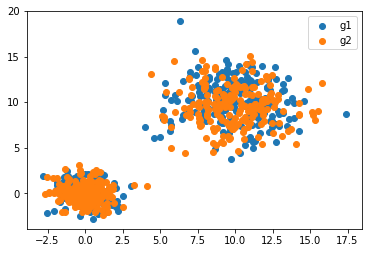

Feedback test of level alpha=0.05
Number of permutations=50
jsd_obs=0.015571730825168521, mean jsd_permutations=0.012853614982934214
Result: H0 accepted, test statistic=8, p_value=0.17647058823529413 >= alpha=0.05
Wall time: 1.43 s


In [7]:
%%time
###################### PARAMETERS ########################
n_permutations = 50  # number of permutation tests
g1 = gaussian_mix(d=2,N=2,t=10,n=200, s=5, seed=1) 
g2 = gaussian_mix(d=2,N=2,t=10,n=200, s=5, seed=2)  # should be identical to g1 except for random seed
##########################################################
plt.scatter(g1[0], g1[1], label="g1")
plt.scatter(g2[0], g2[1], label="g2")
plt.legend()
plt.show()

rd.seed(0)
kofn_power = 0.66
fk = DDBC_feedback(
    g1, g2,
)
fk.permutation_test(n_permutations=n_permutations)
print(fk)

#### Producing results on several gaussian data

In [35]:
def JSD_test(g1,g2,n=50):
    rd.seed(0)
    kofn_power = 0.66
    fk = DDBC_feedback(
        g1, g2,
    )
    fk.permutation_test(n_permutations=n)
    return fk   

In [ ]:
N=100
stat = []
p_val = []
for i in range(N) :
    g1 = gaussian_mix(d=2,N=2,t=i,n=200, s=5, seed=1) 
    g2 = gaussian_mix(d=2,N=2,t=i,n=200, s=5, seed=2)  # should be identical to g1 except for random seed
    fk = JSD_test(g1,g2)
    stat.append(fk.b)
    p_val.append(fk.p_value)plt.plot(stat,label = 'JSD test stat')
plt.legend()
plt.show()

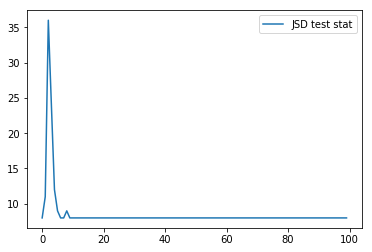

In [33]:
plt.plot(stat,label = 'JSD test stat')
plt.legend()
plt.show()

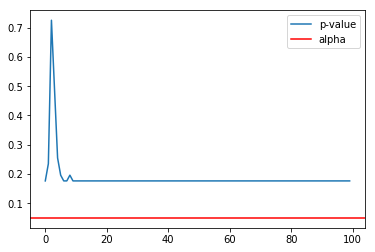

In [34]:
plt.plot(p_val, label = 'p-value')
plt.axhline(y=0.05, color='r', linestyle='-',label = 'alpha')
plt.legend()
plt.show()

P always above alpha, we accept H0 in each case for distribution with p=q

With the same datas as question 3, we have the same result.

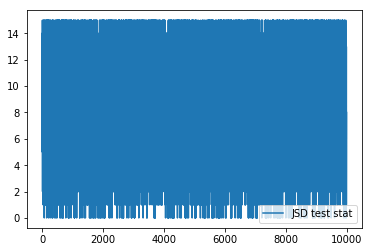

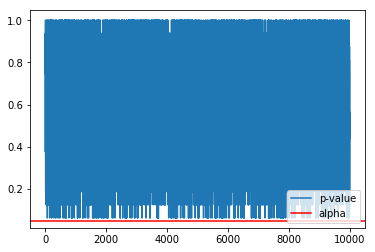

In [43]:
N=10000
stat = []
p_val = []

g1 = gaussian_mix(d=2,N=3,t=1,n=50, seed=0) 
for i in tqdm_notebook(range(1, N+1)):

    g2 = gaussian_mix(d=2,N=3,t=1,n=50, seed=i)  # should be identical to g1 except for random seed
    fk = JSD_test(g1,g2, n=15)
    stat.append(fk.b)
    p_val.append(fk.p_value)

plt.plot(stat,label = 'JSD test stat')
plt.legend()
plt.show()

plt.plot(p_val, label = 'p-value')
plt.axhline(y=0.05, color='r', linestyle='-',label = 'alpha')
plt.legend()
plt.show()

In [53]:
np.mean(np.array(p_val) > 0.05)

1.0

# Question 5 : TST versus feedback under the alternative

Under $H_1$ : test should be rejected

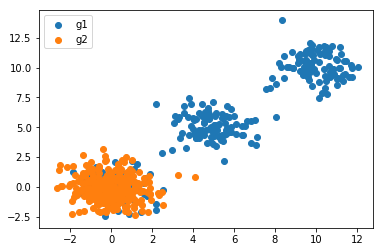

Feedback test of level alpha=0.05
Number of permutations=50
jsd_obs=0.45222371256371524, mean jsd_permutations=0.014271674090087958
Result: H0 rejected, test statistic=0, p_value=0.0196078431372549 < alpha=0.05
Wall time: 1.77 s


In [7]:
%%time
###################### PARAMETERS ########################
n_permutations = 50  # number of permutation tests
g1 = gaussian_mix(d=2,N=3,t=5,n=100, s=1, seed=1) 
g2 = gaussian_mix(d=2,N=3,t=0,n=100, s=1, seed=2)  # should be different from g1
##########################################################

plt.scatter(g1[0], g1[1], label="g1")
plt.scatter(g2[0], g2[1], label="g2")
plt.legend()
plt.show()

rd.seed(0)
kofn_power = 0.66
fk = DDBC_feedback(
    g1, g2,
)
fk.permutation_test(n_permutations=n_permutations)
print(fk)

### Comparison of the variation of the test statistic of MMD, and that of the JS divergence returned by the feedback

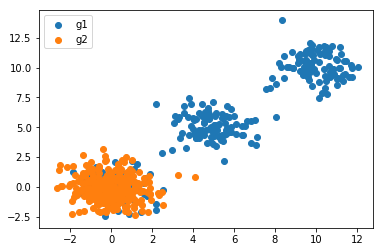

JSD Test statistic
0
MMD Test statistic
0.45602427920900546
Wall time: 1.23 s


In [12]:
%%time
###################### PARAMETERS ########################
n_permutations = 50  # number of permutation tests
g1 = gaussian_mix(d=2,N=3,t=5,n=100, s=1, seed=1) 
g2 = gaussian_mix(d=2,N=3,t=0,n=100, s=1, seed=2)  # should be different from g1
##########################################################

plt.scatter(g1[0], g1[1], label="g1")
plt.scatter(g2[0], g2[1], label="g2")
plt.legend()
plt.show()

rd.seed(0)
kofn_power = 0.66
fk = DDBC_feedback(
    g1, g2,
)
fk.permutation_test(n_permutations=n_permutations)
print('JSD Test statistic')
print(fk.b)

kernel_class = GaussianKernel()
test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)

test.fit(X=g1, Y=g2, verbose=False)
print('MMD Test statistic')
print(test.T)

In [35]:
def compare(g1,g2):
    
    #JSD
    rd.seed(0)
    kofn_power = 0.66
    fk = DDBC_feedback(
        g1, g2,
    )
        
    fk.permutation_test(n_permutations=n_permutations)

    #MMD
    kernel_class = GaussianKernel()
    test = MMD_test(kernel_class=kernel_class, alpha=0.05, biased=True)

    test.fit(X=g1, Y=g2, verbose=False)

    return fk.b, test.T

In [39]:
l_j = []
l_m = []
N = 100

g2 = gaussian_mix(d=2,N=3,t=0,n=100, s=1, seed=2)
for t in range(1,N):
    g1 = gaussian_mix(d=2,N=3,t=t*0.01,n=100, s=1, seed=1)
    comparison  = compare(g1,g2)
    l_j.append(comparison[0])
    l_m.append(comparison[1])
    
df = pd.DataFrame()
df['JSD'] = l_j
df['MMD'] = l_m
df['translation'] = range(1,N)
df['translation'] = df['translation']*0.01

In [40]:
df

,JSD,MMD,translation
0,7,0.090389,0.01
1,6,0.094106,0.02
2,5,0.097857,0.03
3,4,0.101634,0.04
4,3,0.105433,0.05
5,3,0.109248,0.06
6,2,0.113075,0.07
7,2,0.116910,0.08
8,0,0.120751,0.09
9,0,0.124594,0.10


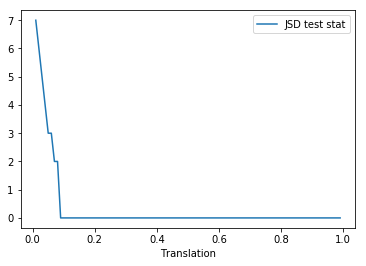

In [43]:
plt.plot(df['translation'],l_j,label ='JSD test stat')
plt.legend()
plt.xlabel('Translation')
plt.show()

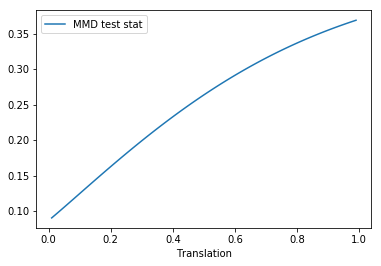

In [44]:
plt.plot(df['translation'],l_m,label ='MMD test stat')
plt.legend()
plt.xlabel('Translation')
plt.show()